In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
years = [2009,2010,2011,2012,2013,2014,2015]
path ='/public/npatil4/dataMining/data/daily/combined_wide/'
files = [path+'combined_wide_'+str(year)+'.csv' for year in years]

In [3]:
data = [pd.read_csv(file_name,sep='|') for file_name in files]

In [4]:
[df.shape for df in data]

[(148428, 18),
 (160416, 18),
 (157975, 18),
 (168291, 18),
 (184197, 18),
 (196085, 18),
 (206363, 18)]

In [5]:
data= pd.concat(data, ignore_index=True)

In [6]:
data['DateLocal'] = pd.to_datetime(data.DateLocal)
data['year'] = data.DateLocal.dt.year
data['weekNo'] = data.DateLocal.dt.week
data['Weekday'] = data.DateLocal.dt.weekday

In [7]:
data.head(2).transpose()

,0,1
DateLocal,2009-01-01 00:00:00,2009-01-01 00:00:00
CityName,Aberdeen,Adjuntas
CountyName,Brown,Adjuntas
StateName,South Dakota,Puerto Rico
Latitude,45.4625,18.17538
Longitude,-98.48611,-66.72599
Barometricpressure,NaN,NaN
Carbonmonoxide,NaN,NaN
DewPoint,NaN,NaN
NitrogenDioxide,NaN,NaN


In [8]:
data_missing = data.isnull()
data_missing_count = data_missing.ix[:,6:-4].apply(sum,1).groupby([data.CountyName,
                                                                   data.CityName]
                                                                 ).mean()
data_missing_count = pd.DataFrame(data_missing_count[data_missing_count>=8]).reset_index()

In [9]:
data_pol = data.ix[:,:-4].groupby([
       'DateLocal',
       'CityName', 'CountyName',
       'Latitude','Longitude'],
        as_index=False).mean()


In [10]:
data_model = pd.read_csv('../data/daily/combined_wide/combined_wide_all_filled_si.txt',
                         sep='|')

In [11]:
data_model['CityName'] = data_pol.CityName
data_model['CityName'] = data_model.CityName.astype('category')
data_model['date'] = data_pol.DateLocal
data_model['weekNo'] = data_model.date.dt.weekofyear
data_model['weekNo'] = data_model.weekNo.astype('category')
data_model['yearNo'] = data_model.date.dt.year
data_model['yearNo'] = data_model.yearNo.astype('category')
data_model['monthNo'] = data_model.date.dt.month
data_model['monthNo'] = data_model.monthNo.astype('category')
data_model['pm_mean_month'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.monthNo]).transform('mean')
data_model['pm_mean_weekNo'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.weekNo]).transform('mean')
data_model['PM'] = pd.Series([0]).append(data_model.PM[:-1]).reset_index(drop=True)

In [12]:
RandomState = 42
train = data_model.sample(frac=0.7,random_state=RandomState)
test = data_model[~(data_model.index.isin(train.index))]

In [13]:
columns = ['Carbonmonoxide',
           'DewPoint',
           'NitrogenDioxide',
           'OutdoorTemperature',
           'Ozone',
           'RelativeHumidity',
           'Sulfurdioxide',
           'weekNo',
           'monthNo',
           'pm_mean_month',
           'pm_mean_weekNo']

In [14]:
X = train[columns]
y = train.PM

#### Linear Regression

In [15]:
regr = LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
scores = cross_val_score(regr, X, y, cv=10)

/software/python/2.7.10/b1/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


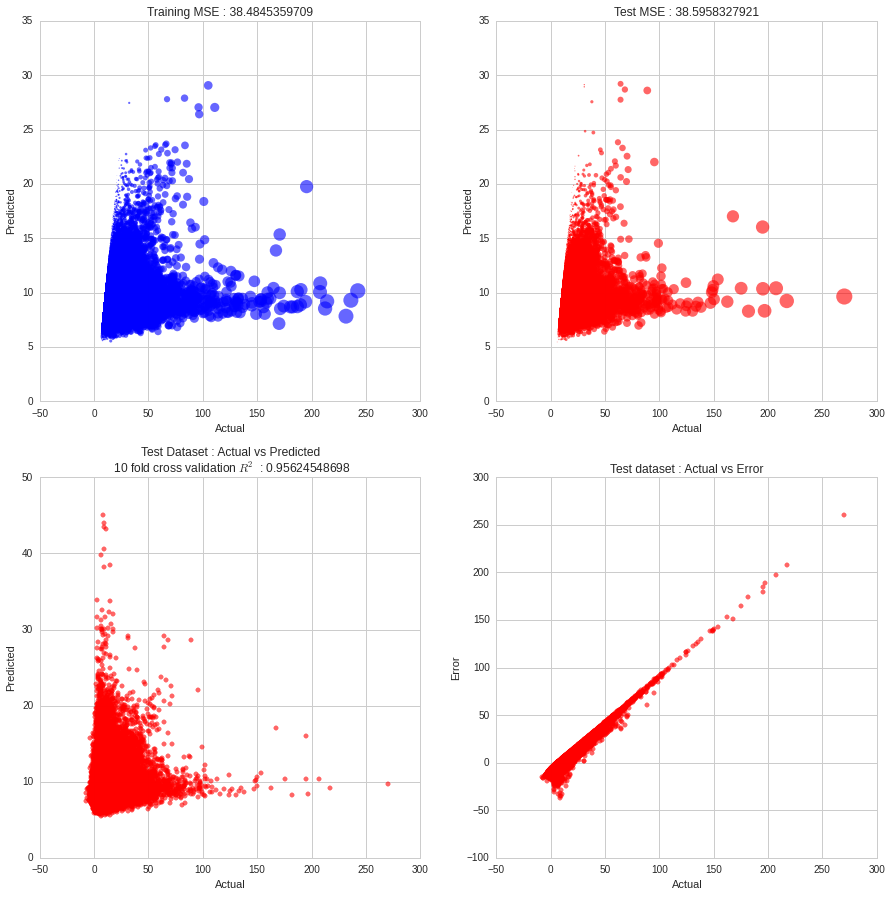

In [17]:
path_plot = '../plots/Matrix_completion_results_'


x_train = train.PM
y_train = regr.predict(X)
error_train = x_train-y_train

x_test = test.PM
y_test = regr.predict(test[X.columns])
error_test = x_test-y_test

q = pd.DataFrame({  'x':x_test,
                    'y':y_test,
                    'error_test':error_test
                }).reset_index(drop=True)
q = q.sort(['x'],inplace=False)


mice_plot = sns.plt.figure(figsize=(15,15))
sns.set_style('whitegrid')


mice_plot.add_subplot(221)
sns.plt.scatter(x_train,
                y_train,
                linewidths=0.0,
                s = error_train,
                c='blue',
                alpha=0.6)
sns.plt.title('Training MSE : '+str(mean_squared_error(x_train,y_train)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(222)
sns.plt.scatter(x_test,
                y_test,
                linewidths=0.0,
                s = error_test,
                c='red',
                alpha=0.6)
sns.plt.title('Test MSE : '+str(mean_squared_error(x_test,y_test)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(223)
sns.plt.scatter(x_test,
                y_test,
                alpha=0.6,
                color='r')
sns.plt.title('Test Dataset : Actual vs Predicted \n 10 fold cross validation $R^2$ : '+
              str(1-np.mean(scores)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(224)
sns.plt.scatter(x = x_test,
                y = error_test,
                alpha=0.6,
                color='r')
sns.plt.title('Test dataset : Actual vs Error')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Error')





plt.savefig(path_plot+'si_month_week_aggregates_rg.png',
            dpi = 750)